In [1]:
#
# Attempts to implement the following:
#
# H. Rave, V. Molchanov and L. Linsen, "Uniform Sample Distribution in Scatterplots via Sector-based Transformation," 
# 2024 IEEE Visualization and Visual Analytics (VIS), St. Pete Beach, FL, USA, 2024, pp. 156-160, 
# doi: 10.1109/VIS55277.2024.00039. 
# keywords: {Data analysis;Visual analytics;Clutter;Scatterplot de-cluttering;spatial transformation},
#
import polars as pl
import numpy as np
from math import cos, sin, pi, sqrt, atan2
from shapely import Polygon
from   udist_scatterplots_via_sectors          import UDistScatterPlotsViaSectors, xyUniformSampleDistributionSectorTransformDEBUG, xyUniformSampleDistributionSectorTransform
from   udist_scatterplots_via_sectors_tile_opt import UDistScatterPlotsViaSectorsTileOpt
import time
import rtsvg
rt = rtsvg.RACETrack()
import random
num_of_pts   = [1_000, 2_000, 500]
circle_geoms = [(5,5,1),(20,10,2),(8,8,1)]
colors       = ['#ff0000','#006400','#0000ff']
_xvals_, _yvals_, _weights_, _colors_ = [12.0], [8.0], [1.0], ['#000000']
for i in range(len(num_of_pts)):
    for j in range(num_of_pts[i]):
        a, l = random.random() * 2 * pi, random.random() * circle_geoms[i][2]
        x, y = circle_geoms[i][0] + l * cos(a), circle_geoms[i][1] + l * sin(a)
        _xvals_.append(x), _yvals_.append(y), _weights_.append(1.0), _colors_.append(colors[i])

_iterations_ = 2

#x_new, y_new, svgs, svgs_for_sectors, svg_animation, df_fine = xyUniformSampleDistributionSectorTransformDEBUG(rt, _xvals_, _yvals_, _weights_, _colors_, iterations=_iterations_)

t0 = time.time()
#xyUniformSampleDistributionSectorTransform(rt, _xvals_, _yvals_, _weights_, _colors_, iterations=_iterations_)
t1 = time.time()
udspvs          = UDistScatterPlotsViaSectors(_xvals_, _yvals_, _weights_, _colors_, iterations=_iterations_, debug=True)
t2 = time.time()
udspvs_tile_opt = UDistScatterPlotsViaSectorsTileOpt(_xvals_, _yvals_, _weights_, _colors_, iterations=_iterations_, debug=True, num_of_tiles=256)
t3 = time.time()

#
# Comparison (w/ fixed implementation)
# 351 Points (128 Iterations), 18.74s Reference Time, 1.66s Polars Time | (M1 Pro 16G) 
# 351 Points (256 Iterations), 38.45s Reference Time, 7.28s Polars Time | (M1 Pro 16G)
# 351 Points (128 Iterations), 19.41s Reference Time, 1.40s Polars Time, 3.40s Polars Tile Opt Time | (M1 Pro 16G)
# 3501 Points (4 Iterations), 32.75s Reference Time, 2.40s Polars Time, 2.75s Polars Tile Opt Time | (M1 Pro 16G)
# 3501 Points (16 Iterations), 130.43s Reference Time, 23.11s Polars Time, 8.06s Polars Tile Opt Time | (M1 Pro 16G)
# 1751 Points (128 Iterations), 0.00s Reference Time, 23.34s Polars Time, 20.33s Polars Tile Opt Time | (M1 Pro 16G) (after making a file for the xoyo data)
# 3501 Points (128 Iterations), 0.00s Reference Time, 59.83s Polars Time, 70.97s Polars Tile Opt Time | (M1 Pro 16G) [debug=False]
# 3501 Points (32 Iterations), 0.00s Reference Time, 14.21s Polars Time, 12.97s Polars Tile Opt Time | (M1 Pro 16G) [debug=False, num_of_tiles=64]
# 3501 Points (32 Iterations), 0.00s Reference Time, 13.85s Polars Time, 13.61s Polars Tile Opt Time | (M1 Pro 16G) [debug=False, num_of_tiles=128]
# 3501 Points (32 Iterations), 0.00s Reference Time, 19.51s Polars Time, 17.25s Polars Tile Opt Time | (7900x 96G) [debug=False, num_of_tiles=128]
#
print(f'{len(_xvals_)} Points ({_iterations_} Iterations), {t1-t0:.2f}s Reference Time, {t2-t1:.2f}s Polars Time, {t3-t2:.2f}s Polars Tile Opt Time | (M1 Pro 16G) ')
#rt.tile([svg_animation, udspvs.animateIterations(animation_dur="4s"), udspvs_tile_opt.animateIterations(animation_dur="4s")], spacer=10)
rt.tile([udspvs.animateIterations(animation_dur="4s"), udspvs_tile_opt.animateIterations(animation_dur="4s")], spacer=10)

3501 Points (2 Iterations), 0.00s Reference Time, 1.99s Polars Time, 2.19s Polars Tile Opt Time | (M1 Pro 16G) 


In [2]:
# 2048 Iterations w/ 351 Points | M1 Pro 16G
#
#                 sector_sums | 3.959
#                 arctangents | 2.436
#   ray_segment_intersections | 2.289
#              explode_points | 2.251
#         add_missing_sectors | 1.839
#                   area_calc | 1.254
#         sector_uv_summation | 0.907
#                point_update | 0.784
#       prepare_sector_angles | 0.659
#          join_sector_angles | 0.592
#                 all_sectors | 0.421
#                   normalize | 0.269
#                  prepare_df | 0.000
udspvs = UDistScatterPlotsViaSectors(_xvals_, _yvals_, _weights_, _colors_, iterations=16)
_lu_ = {'subroutine':[], 'time':[]}
for k in udspvs.time_lu: _lu_['subroutine'].append(k), _lu_['time'].append(udspvs.time_lu[k])
_df_ = pl.DataFrame(_lu_).sort(by='time', descending=True)
for i in range(len(_df_['subroutine'])): print(f'{_df_["subroutine"][i]:>28} | {_df_["time"][i]:.3f}')

                 sector_sums | 7.850
              explode_points | 2.680
                 arctangents | 1.553
         add_missing_sectors | 0.038
   ray_segment_intersections | 0.032
                   area_calc | 0.019
         sector_uv_summation | 0.018
          join_sector_angles | 0.010
                point_update | 0.009
       prepare_sector_angles | 0.006
                 all_sectors | 0.006
                   normalize | 0.003
                  prepare_df | 0.001


In [3]:
import copy
timing   = {'pts':[], 'iters':[], 'time':[]}
time_lus = []
for num_pts in [10,20,30]: # [1000, 1500, 2000]:
    for num_iter in [1,2,3]: # [4, 8, 12]: # [16, 32, 64, 128, 256]:
        _xvals_, _yvals_, []
        for i in range(num_pts):
            x, y = random.random() * 100, random.random() * 100
            _xvals_.append(x), _yvals_.append(y)
        t0 = time.time()
        udspvs = UDistScatterPlotsViaSectors(_xvals_, _yvals_, iterations=num_iter)
        t1 = time.time()
        print(f'{num_pts:>5} Pts | {num_iter:>3} Iters | {t1-t0:.2f}s')
        timing['pts'].append(num_pts), timing['iters'].append(num_iter), timing['time'].append(t1-t0)
        time_lus.append(copy.deepcopy(udspvs.time_lu))
#rt.xy(pl.DataFrame(timing), x_field='iters', y_field='time', line_groupby_field='pts', color_by='pts') #._repr_svg_()

   10 Pts |   1 Iters | 0.60s
   10 Pts |   2 Iters | 1.03s
   10 Pts |   3 Iters | 1.59s
   20 Pts |   1 Iters | 0.56s
   20 Pts |   2 Iters | 1.21s
   20 Pts |   3 Iters | 1.84s
   30 Pts |   1 Iters | 0.59s
   30 Pts |   2 Iters | 1.14s
   30 Pts |   3 Iters | 1.76s


'<svg id="xy_13657337" x="0" y="0" width="256" height="256" xmlns="http://www.w3.org/2000/svg"><rect width="255" height="255" x="0" y="0" fill="#ffffff" fill-opacity="1.0" stroke="#ffffff" stroke-opacity="1.0" /><path d="M 17 239 L 17 3 L 251 3 L 251 239 Z" stroke="#101010" stroke-width=".4" fill="none" /><polyline points="17,237 32,233 63,226 126,213 251,185 " stroke="#b3c79f" stroke-width="1" fill="none" /><polyline points="17,231 32,223 63,207 126,174 251,108 " stroke="#4166ce" stroke-width="1" fill="none" /><polyline points="17,225 32,209 63,181 126,123 251,3 " stroke="#72b1b4" stroke-width="1" fill="none" /><circle  cx="32" cy="209" r="2" fill="#72b1b4" stroke="#72b1b4" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="63" cy="181" r="2" fill="#72b1b4" stroke="#72b1b4" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="251" cy="185" r="2" fill="#b3c79f" stroke="#b3c79f" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="17" cy="231" r="2" fill="#4166ce" stroke="#4166ce" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="32" cy="223" r="2" fill="#4166ce" stroke="#4166ce" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="63" cy="226" r="2" fill="#b3c79f" stroke="#b3c79f" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="32" cy="233" r="2" fill="#b3c79f" stroke="#b3c79f" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="251" cy="3" r="2" fill="#72b1b4" stroke="#72b1b4" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="126" cy="174" r="2" fill="#4166ce" stroke="#4166ce" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="17" cy="237" r="2" fill="#b3c79f" stroke="#b3c79f" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="251" cy="108" r="2" fill="#4166ce" stroke="#4166ce" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="126" cy="213" r="2" fill="#b3c79f" stroke="#b3c79f" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="17" cy="225" r="2" fill="#72b1b4" stroke="#72b1b4" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="63" cy="207" r="2" fill="#4166ce" stroke="#4166ce" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="126" cy="123" r="2" fill="#72b1b4" stroke="#72b1b4" fill-opacity="1.0" stroke-opacity="1.0" /><text x="17" text-anchor="start" y="253" font-family="Times" fill="#000000" font-size="12px">16</text><text x="251" text-anchor="end" y="253" font-family="Times" fill="#000000" font-size="12px">256</text><text x="134.0" text-anchor="middle" y="253" font-family="Times" fill="#000000" font-size="12px">iters</text><text x="13" text-anchor="start" y="237" font-family="Times" fill="#000000" font-size="12px" transform="rotate(-90,13,237)">0.5</text><text x="13" text-anchor="end" y="3" font-family="Times" fill="#000000" font-size="12px" transform="rotate(-90,13,3)">36.0</text><text x="13" text-anchor="middle" y="120.0" font-family="Times" fill="#000000" font-size="12px" transform="rotate(-90,13,120.0)">time</text><rect width="255" height="256" x="0" y="0" fill-opacity="0.0" fill="none" stroke="#000000" /></svg>'

In [4]:
#
# performance issues (in order): sector_sums ... then explode_points ... then arctangents
#
_lu_ = {'pts':[], 'iters':[], 'subroutine':[], 'subroutine_time':[]}
for i in range(len(time_lus)):
    _time_lu_               = time_lus[i]
    _pts_, _iters_, _times_ = timing['pts'][i], timing['iters'][i], timing['time'][i]
    for k in _time_lu_:
        _lu_['pts'].append(_pts_), _lu_['iters'].append(_iters_), _lu_['subroutine'].append(k), _lu_['subroutine_time'].append(_time_lu_[k])

#rt.smallMultiples(pl.DataFrame(_lu_), category_by='subroutine', sm_type='xy', y_axis_independent=False,
#                  sm_params={'x_field':'iters', 'y_field':'subroutine_time', 'line_groupby_field':'pts', 'color_by':'pts'},
#                  sort_by='field', sort_by_field='subroutine_time',
#                  h_sm_override=128, w_sm_override=256, w=1300) # ._repr_svg_()

'<svg id="smallMultiples_21023" x="0" y="0" width="1292" height="438" xmlns="http://www.w3.org/2000/svg"><rect width="1291" height="437" x="0" y="0" fill="#ffffff" stroke="#ffffff" /><svg id="smallMultiples_21023_0" x="2" y="2" width="256" height="128" xmlns="http://www.w3.org/2000/svg"><rect width="255" height="127" x="0" y="0" fill="#ffffff" fill-opacity="1.0" stroke="#ffffff" stroke-opacity="1.0" /><path d="M 17 111 L 17 3 L 251 3 L 251 111 Z" stroke="#101010" stroke-width=".4" fill="none" /><polyline points="17,105 32,102 63,95 126,82 251,56 " stroke="#4166ce" stroke-width="1" fill="none" /><polyline points="17,107 32,106 63,103 126,99 251,88 " stroke="#b3c79f" stroke-width="1" fill="none" /><polyline points="17,102 32,95 63,82 126,56 251,3 " stroke="#72b1b4" stroke-width="1" fill="none" /><circle  cx="32" cy="95" r="2" fill="#72b1b4" stroke="#72b1b4" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="126" cy="99" r="2" fill="#b3c79f" stroke="#b3c79f" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="32" cy="106" r="2" fill="#b3c79f" stroke="#b3c79f" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="251" cy="3" r="2" fill="#72b1b4" stroke="#72b1b4" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="63" cy="103" r="2" fill="#b3c79f" stroke="#b3c79f" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="32" cy="102" r="2" fill="#4166ce" stroke="#4166ce" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="63" cy="82" r="2" fill="#72b1b4" stroke="#72b1b4" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="126" cy="56" r="2" fill="#72b1b4" stroke="#72b1b4" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="17" cy="107" r="2" fill="#b3c79f" stroke="#b3c79f" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="251" cy="56" r="2" fill="#4166ce" stroke="#4166ce" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="251" cy="88" r="2" fill="#b3c79f" stroke="#b3c79f" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="17" cy="105" r="2" fill="#4166ce" stroke="#4166ce" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="63" cy="95" r="2" fill="#4166ce" stroke="#4166ce" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="17" cy="102" r="2" fill="#72b1b4" stroke="#72b1b4" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="126" cy="82" r="2" fill="#4166ce" stroke="#4166ce" fill-opacity="1.0" stroke-opacity="1.0" /><text x="17" text-anchor="start" y="125" font-family="Times" fill="#000000" font-size="12px">16</text><text x="251" text-anchor="end" y="125" font-family="Times" fill="#000000" font-size="12px">256</text><text x="134.0" text-anchor="middle" y="125" font-family="Times" fill="#000000" font-size="12px">iters</text><text x="13" text-anchor="start" y="109" font-family="Times" fill="#000000" font-size="12px" transform="rotate(-90,13,109)">0.0</text><text x="13" text-anchor="end" y="3" font-family="Times" fill="#000000" font-size="12px" transform="rotate(-90,13,3)">18.3</text><rect width="255" height="128" x="0" y="0" fill-opacity="0.0" fill="none" stroke="#000000" /></svg><text x="130.0" text-anchor="middle" y="142" font-family="Times" fill="#000000" font-size="14px">sector_sums</text><svg id="smallMultiples_21023_1" x="260" y="2" width="256" height="128" xmlns="http://www.w3.org/2000/svg"><rect width="255" height="127" x="0" y="0" fill="#ffffff" fill-opacity="1.0" stroke="#ffffff" stroke-opacity="1.0" /><path d="M 17 111 L 17 3 L 251 3 L 251 111 Z" stroke="#101010" stroke-width=".4" fill="none" /><polyline points="17,106 32,103 63,97 126,85 251,59 " stroke="#72b1b4" stroke-width="1" fill="none" /><polyline points="17,108 32,108 63,107 126,105 251,101 " stroke="#b3c79f" stroke-width="1" fill="none" /><polyline points="17,107 32,105 63,102 126,94 251,80 " stroke="#4166ce" stroke-width="1" fill="none" /><circle  cx="32" cy="108" r="2" fill="#b3c79f" stroke="#b3c79f" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="32" cy="103" r="2" fill="#72b1b4" stroke="#72b1b4" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="63" cy="97" r="2" fill="#72b1b4" stroke="#72b1b4" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="126" cy="105" r="2" fill="#b3c79f" stroke="#b3c79f" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="17" cy="106" r="2" fill="#72b1b4" stroke="#72b1b4" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="251" cy="80" r="2" fill="#4166ce" stroke="#4166ce" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="63" cy="107" r="2" fill="#b3c79f" stroke="#b3c79f" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="17" cy="108" r="2" fill="#b3c79f" stroke="#b3c79f" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="32" cy="105" r="2" fill="#4166ce" stroke="#4166ce" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="126" cy="85" r="2" fill="#72b1b4" stroke="#72b1b4" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="251" cy="101" r="2" fill="#b3c79f" stroke="#b3c79f" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="126" cy="94" r="2" fill="#4166ce" stroke="#4166ce" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="17" cy="107" r="2" fill="#4166ce" stroke="#4166ce" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="251" cy="59" r="2" fill="#72b1b4" stroke="#72b1b4" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="63" cy="102" r="2" fill="#4166ce" stroke="#4166ce" fill-opacity="1.0" stroke-opacity="1.0" /><text x="17" text-anchor="start" y="125" font-family="Times" fill="#000000" font-size="12px">16</text><text x="251" text-anchor="end" y="125" font-family="Times" fill="#000000" font-size="12px">256</text><text x="134.0" text-anchor="middle" y="125" font-family="Times" fill="#000000" font-size="12px">iters</text><text x="13" text-anchor="start" y="109" font-family="Times" fill="#000000" font-size="12px" transform="rotate(-90,13,109)">0.0</text><text x="13" text-anchor="end" y="3" font-family="Times" fill="#000000" font-size="12px" transform="rotate(-90,13,3)">18.3</text><rect width="255" height="128" x="0" y="0" fill-opacity="0.0" fill="none" stroke="#000000" /></svg><text x="388.0" text-anchor="middle" y="142" font-family="Times" fill="#000000" font-size="14px">explode_points</text><svg id="smallMultiples_21023_2" x="518" y="2" width="256" height="128" xmlns="http://www.w3.org/2000/svg"><rect width="255" height="127" x="0" y="0" fill="#ffffff" fill-opacity="1.0" stroke="#ffffff" stroke-opacity="1.0" /><path d="M 17 111 L 17 3 L 251 3 L 251 111 Z" stroke="#101010" stroke-width=".4" fill="none" /><polyline points="17,105 32,103 63,98 126,88 251,68 " stroke="#72b1b4" stroke-width="1" fill="none" /><polyline points="17,108 32,107 63,106 126,103 251,97 " stroke="#b3c79f" stroke-width="1" fill="none" /><polyline points="17,107 32,105 63,102 126,97 251,85 " stroke="#4166ce" stroke-width="1" fill="none" /><circle  cx="251" cy="85" r="2" fill="#4166ce" stroke="#4166ce" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="126" cy="88" r="2" fill="#72b1b4" stroke="#72b1b4" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="126" cy="97" r="2" fill="#4166ce" stroke="#4166ce" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="251" cy="68" r="2" fill="#72b1b4" stroke="#72b1b4" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="126" cy="103" r="2" fill="#b3c79f" stroke="#b3c79f" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="32" cy="103" r="2" fill="#72b1b4" stroke="#72b1b4" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="17" cy="107" r="2" fill="#4166ce" stroke="#4166ce" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="17" cy="105" r="2" fill="#72b1b4" stroke="#72b1b4" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="63" cy="98" r="2" fill="#72b1b4" stroke="#72b1b4" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="63" cy="102" r="2" fill="#4166ce" stroke="#4166ce" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="251" cy="97" r="2" fill="#b3c79f" stroke="#b3c79f" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="63" cy="106" r="2" fill="#b3c79f" stroke="#b3c79f" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="17" cy="108" r="2" fill="#b3c79f" stroke="#b3c79f" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="32" cy="107" r="2" fill="#b3c79f" stroke="#b3c79f" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="32" cy="105" r="2" fill="#4166ce" stroke="#4166ce" fill-opacity="1.0" stroke-opacity="1.0" /><text x="17" text-anchor="start" y="125" font-family="Times" fill="#000000" font-size="12px">16</text><text x="251" text-anchor="end" y="125" font-family="Times" fill="#000000" font-size="12px">256</text><text x="134.0" text-anchor="middle" y="125" font-family="Times" fill="#000000" font-size="12px">iters</text><text x="13" text-anchor="start" y="109" font-family="Times" fill="#000000" font-size="12px" transform="rotate(-90,13,109)">0.0</text><text x="13" text-anchor="end" y="3" font-family="Times" fill="#000000" font-size="12px" transform="rotate(-90,13,3)">18.3</text><rect width="255" height="128" x="0" y="0" fill-opacity="0.0" fill="none" stroke="#000000" /></svg><text x="646.0" text-anchor="middle" y="142" font-family="Times" fill="#000000" font-size="14px">arctangents</text><svg id="smallMultiples_21023_3" x="776" y="2" width="256" height="128" xmlns="http://www.w3.org/2000/svg"><rect width="255" height="127" x="0" y="0" fill="#ffffff" fill-opacity="1.0" stroke="#ffffff" stroke-opacity="1.0" /><path d="M 17 111 L 17 3 L 251 3 L 251 111 Z" stroke="#101010" stroke-width=".4" fill="none" /><polyline points="17,108 32,108 63,108 126,107 251,106 " stroke="#b3c79f" stroke-width="1" fill="none" /><polyline points="17,108 32,108 63,108 126,107 251,105 " stroke="#72b1b4" stroke-width="1" fill="none" /><polyline points="17,108 32,108 63,108 126,107 251,106 " stroke="#4166ce" stroke-width="1" fill="none" /><circle  cx="251" cy="105" r="2" fill="#72b1b4" stroke="#72b1b4" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="32" cy="108" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="63" cy="108" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="17" cy="108" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="251" cy="106" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="126" cy="107" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><text x="17" text-anchor="start" y="125" font-family="Times" fill="#000000" font-size="12px">16</text><text x="251" text-anchor="end" y="125" font-family="Times" fill="#000000" font-size="12px">256</text><text x="134.0" text-anchor="middle" y="125" font-family="Times" fill="#000000" font-size="12px">iters</text><text x="13" text-anchor="start" y="109" font-family="Times" fill="#000000" font-size="12px" transform="rotate(-90,13,109)">0.0</text><text x="13" text-anchor="end" y="3" font-family="Times" fill="#000000" font-size="12px" transform="rotate(-90,13,3)">18.3</text><rect width="255" height="128" x="0" y="0" fill-opacity="0.0" fill="none" stroke="#000000" /></svg><text x="904.0" text-anchor="middle" y="142" font-family="Times" fill="#000000" font-size="14px">add_missing_sectors</text><svg id="smallMultiples_21023_4" x="1034" y="2" width="256" height="128" xmlns="http://www.w3.org/2000/svg"><rect width="255" height="127" x="0" y="0" fill="#ffffff" fill-opacity="1.0" stroke="#ffffff" stroke-opacity="1.0" /><path d="M 17 111 L 17 3 L 251 3 L 251 111 Z" stroke="#101010" stroke-width=".4" fill="none" /><polyline points="17,108 32,108 63,108 126,107 251,106 " stroke="#72b1b4" stroke-width="1" fill="none" /><polyline points="17,108 32,108 63,108 126,107 251,106 " stroke="#b3c79f" stroke-width="1" fill="none" /><polyline points="17,108 32,108 63,108 126,107 251,106 " stroke="#4166ce" stroke-width="1" fill="none" /><circle  cx="17" cy="108" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="251" cy="106" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="32" cy="108" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="63" cy="108" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="126" cy="107" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><text x="17" text-anchor="start" y="125" font-family="Times" fill="#000000" font-size="12px">16</text><text x="251" text-anchor="end" y="125" font-family="Times" fill="#000000" font-size="12px">256</text><text x="134.0" text-anchor="middle" y="125" font-family="Times" fill="#000000" font-size="12px">iters</text><text x="13" text-anchor="start" y="109" font-family="Times" fill="#000000" font-size="12px" transform="rotate(-90,13,109)">0.0</text><text x="13" text-anchor="end" y="3" font-family="Times" fill="#000000" font-size="12px" transform="rotate(-90,13,3)">18.3</text><rect width="255" height="128" x="0" y="0" fill-opacity="0.0" fill="none" stroke="#000000" /></svg><text x="1162.0" text-anchor="middle" y="142" font-family="Times" fill="#000000" font-size="14px">ray_segment_intersections</text><svg id="smallMultiples_21023_5" x="2" y="148" width="256" height="128" xmlns="http://www.w3.org/2000/svg"><rect width="255" height="127" x="0" y="0" fill="#ffffff" fill-opacity="1.0" stroke="#ffffff" stroke-opacity="1.0" /><path d="M 17 111 L 17 3 L 251 3 L 251 111 Z" stroke="#101010" stroke-width=".4" fill="none" /><polyline points="17,108 32,108 63,108 126,108 251,107 " stroke="#72b1b4" stroke-width="1" fill="none" /><polyline points="17,108 32,108 63,108 126,108 251,107 " stroke="#4166ce" stroke-width="1" fill="none" /><polyline points="17,108 32,108 63,108 126,108 251,107 " stroke="#b3c79f" stroke-width="1" fill="none" /><circle  cx="63" cy="108" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="17" cy="108" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="126" cy="108" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="251" cy="107" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="32" cy="108" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><text x="17" text-anchor="start" y="125" font-family="Times" fill="#000000" font-size="12px">16</text><text x="251" text-anchor="end" y="125" font-family="Times" fill="#000000" font-size="12px">256</text><text x="134.0" text-anchor="middle" y="125" font-family="Times" fill="#000000" font-size="12px">iters</text><text x="13" text-anchor="start" y="109" font-family="Times" fill="#000000" font-size="12px" transform="rotate(-90,13,109)">0.0</text><text x="13" text-anchor="end" y="3" font-family="Times" fill="#000000" font-size="12px" transform="rotate(-90,13,3)">18.3</text><rect width="255" height="128" x="0" y="0" fill-opacity="0.0" fill="none" stroke="#000000" /></svg><text x="130.0" text-anchor="middle" y="288" font-family="Times" fill="#000000" font-size="14px">area_calc</text><svg id="smallMultiples_21023_6" x="260" y="148" width="256" height="128" xmlns="http://www.w3.org/2000/svg"><rect width="255" height="127" x="0" y="0" fill="#ffffff" fill-opacity="1.0" stroke="#ffffff" stroke-opacity="1.0" /><path d="M 17 111 L 17 3 L 251 3 L 251 111 Z" stroke="#101010" stroke-width=".4" fill="none" /><polyline points="17,108 32,108 63,108 126,108 251,107 " stroke="#72b1b4" stroke-width="1" fill="none" /><polyline points="17,108 32,108 63,108 126,108 251,107 " stroke="#b3c79f" stroke-width="1" fill="none" /><polyline points="17,108 32,108 63,108 126,108 251,107 " stroke="#4166ce" stroke-width="1" fill="none" /><circle  cx="17" cy="108" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="251" cy="107" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="32" cy="108" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="63" cy="108" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="126" cy="108" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><text x="17" text-anchor="start" y="125" font-family="Times" fill="#000000" font-size="12px">16</text><text x="251" text-anchor="end" y="125" font-family="Times" fill="#000000" font-size="12px">256</text><text x="134.0" text-anchor="middle" y="125" font-family="Times" fill="#000000" font-size="12px">iters</text><text x="13" text-anchor="start" y="109" font-family="Times" fill="#000000" font-size="12px" transform="rotate(-90,13,109)">0.0</text><text x="13" text-anchor="end" y="3" font-family="Times" fill="#000000" font-size="12px" transform="rotate(-90,13,3)">18.3</text><rect width="255" height="128" x="0" y="0" fill-opacity="0.0" fill="none" stroke="#000000" /></svg><text x="388.0" text-anchor="middle" y="288" font-family="Times" fill="#000000" font-size="14px">sector_uv_summation</text><svg id="smallMultiples_21023_7" x="518" y="148" width="256" height="128" xmlns="http://www.w3.org/2000/svg"><rect width="255" height="127" x="0" y="0" fill="#ffffff" fill-opacity="1.0" stroke="#ffffff" stroke-opacity="1.0" /><path d="M 17 111 L 17 3 L 251 3 L 251 111 Z" stroke="#101010" stroke-width=".4" fill="none" /><polyline points="17,108 32,108 63,108 126,108 251,108 " stroke="#b3c79f" stroke-width="1" fill="none" /><polyline points="17,108 32,108 63,108 126,108 251,108 " stroke="#4166ce" stroke-width="1" fill="none" /><polyline points="17,108 32,108 63,108 126,108 251,108 " stroke="#72b1b4" stroke-width="1" fill="none" /><circle  cx="126" cy="108" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="251" cy="108" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="63" cy="108" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="17" cy="108" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="32" cy="108" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><text x="17" text-anchor="start" y="125" font-family="Times" fill="#000000" font-size="12px">16</text><text x="251" text-anchor="end" y="125" font-family="Times" fill="#000000" font-size="12px">256</text><text x="134.0" text-anchor="middle" y="125" font-family="Times" fill="#000000" font-size="12px">iters</text><text x="13" text-anchor="start" y="109" font-family="Times" fill="#000000" font-size="12px" transform="rotate(-90,13,109)">0.0</text><text x="13" text-anchor="end" y="3" font-family="Times" fill="#000000" font-size="12px" transform="rotate(-90,13,3)">18.3</text><rect width="255" height="128" x="0" y="0" fill-opacity="0.0" fill="none" stroke="#000000" /></svg><text x="646.0" text-anchor="middle" y="288" font-family="Times" fill="#000000" font-size="14px">point_update</text><svg id="smallMultiples_21023_8" x="776" y="148" width="256" height="128" xmlns="http://www.w3.org/2000/svg"><rect width="255" height="127" x="0" y="0" fill="#ffffff" fill-opacity="1.0" stroke="#ffffff" stroke-opacity="1.0" /><path d="M 17 111 L 17 3 L 251 3 L 251 111 Z" stroke="#101010" stroke-width=".4" fill="none" /><polyline points="17,108 32,108 63,108 126,108 251,108 " stroke="#72b1b4" stroke-width="1" fill="none" /><polyline points="17,108 32,108 63,108 126,108 251,108 " stroke="#4166ce" stroke-width="1" fill="none" /><polyline points="17,108 32,108 63,108 126,108 251,108 " stroke="#b3c79f" stroke-width="1" fill="none" /><circle  cx="126" cy="108" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="17" cy="108" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="32" cy="108" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="63" cy="108" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="251" cy="108" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><text x="17" text-anchor="start" y="125" font-family="Times" fill="#000000" font-size="12px">16</text><text x="251" text-anchor="end" y="125" font-family="Times" fill="#000000" font-size="12px">256</text><text x="134.0" text-anchor="middle" y="125" font-family="Times" fill="#000000" font-size="12px">iters</text><text x="13" text-anchor="start" y="109" font-family="Times" fill="#000000" font-size="12px" transform="rotate(-90,13,109)">0.0</text><text x="13" text-anchor="end" y="3" font-family="Times" fill="#000000" font-size="12px" transform="rotate(-90,13,3)">18.3</text><rect width="255" height="128" x="0" y="0" fill-opacity="0.0" fill="none" stroke="#000000" /></svg><text x="904.0" text-anchor="middle" y="288" font-family="Times" fill="#000000" font-size="14px">join_sector_angles</text><svg id="smallMultiples_21023_9" x="1034" y="148" width="256" height="128" xmlns="http://www.w3.org/2000/svg"><rect width="255" height="127" x="0" y="0" fill="#ffffff" fill-opacity="1.0" stroke="#ffffff" stroke-opacity="1.0" /><path d="M 17 111 L 17 3 L 251 3 L 251 111 Z" stroke="#101010" stroke-width=".4" fill="none" /><polyline points="17,108 32,108 63,108 126,108 251,108 " stroke="#4166ce" stroke-width="1" fill="none" /><polyline points="17,108 32,108 63,108 126,108 251,108 " stroke="#b3c79f" stroke-width="1" fill="none" /><polyline points="17,108 32,108 63,108 126,108 251,108 " stroke="#72b1b4" stroke-width="1" fill="none" /><circle  cx="17" cy="108" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="63" cy="108" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="251" cy="108" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="32" cy="108" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="126" cy="108" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><text x="17" text-anchor="start" y="125" font-family="Times" fill="#000000" font-size="12px">16</text><text x="251" text-anchor="end" y="125" font-family="Times" fill="#000000" font-size="12px">256</text><text x="134.0" text-anchor="middle" y="125" font-family="Times" fill="#000000" font-size="12px">iters</text><text x="13" text-anchor="start" y="109" font-family="Times" fill="#000000" font-size="12px" transform="rotate(-90,13,109)">0.0</text><text x="13" text-anchor="end" y="3" font-family="Times" fill="#000000" font-size="12px" transform="rotate(-90,13,3)">18.3</text><rect width="255" height="128" x="0" y="0" fill-opacity="0.0" fill="none" stroke="#000000" /></svg><text x="1162.0" text-anchor="middle" y="288" font-family="Times" fill="#000000" font-size="14px">prepare_sector_angles</text><svg id="smallMultiples_21023_10" x="2" y="294" width="256" height="128" xmlns="http://www.w3.org/2000/svg"><rect width="255" height="127" x="0" y="0" fill="#ffffff" fill-opacity="1.0" stroke="#ffffff" stroke-opacity="1.0" /><path d="M 17 111 L 17 3 L 251 3 L 251 111 Z" stroke="#101010" stroke-width=".4" fill="none" /><polyline points="17,108 32,108 63,108 126,108 251,108 " stroke="#72b1b4" stroke-width="1" fill="none" /><polyline points="17,108 32,108 63,108 126,108 251,108 " stroke="#b3c79f" stroke-width="1" fill="none" /><polyline points="17,108 32,108 63,108 126,108 251,108 " stroke="#4166ce" stroke-width="1" fill="none" /><circle  cx="251" cy="108" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="126" cy="108" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="32" cy="108" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="63" cy="108" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="17" cy="108" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><text x="17" text-anchor="start" y="125" font-family="Times" fill="#000000" font-size="12px">16</text><text x="251" text-anchor="end" y="125" font-family="Times" fill="#000000" font-size="12px">256</text><text x="134.0" text-anchor="middle" y="125" font-family="Times" fill="#000000" font-size="12px">iters</text><text x="13" text-anchor="start" y="109" font-family="Times" fill="#000000" font-size="12px" transform="rotate(-90,13,109)">0.0</text><text x="13" text-anchor="end" y="3" font-family="Times" fill="#000000" font-size="12px" transform="rotate(-90,13,3)">18.3</text><rect width="255" height="128" x="0" y="0" fill-opacity="0.0" fill="none" stroke="#000000" /></svg><text x="130.0" text-anchor="middle" y="434" font-family="Times" fill="#000000" font-size="14px">all_sectors</text><svg id="smallMultiples_21023_11" x="260" y="294" width="256" height="128" xmlns="http://www.w3.org/2000/svg"><rect width="255" height="127" x="0" y="0" fill="#ffffff" fill-opacity="1.0" stroke="#ffffff" stroke-opacity="1.0" /><path d="M 17 111 L 17 3 L 251 3 L 251 111 Z" stroke="#101010" stroke-width=".4" fill="none" /><polyline points="17,108 32,108 63,108 126,108 251,108 " stroke="#4166ce" stroke-width="1" fill="none" /><polyline points="17,108 32,108 63,108 126,108 251,108 " stroke="#72b1b4" stroke-width="1" fill="none" /><polyline points="17,108 32,108 63,108 126,108 251,108 " stroke="#b3c79f" stroke-width="1" fill="none" /><circle  cx="63" cy="108" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="32" cy="108" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="251" cy="108" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="17" cy="108" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="126" cy="108" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><text x="17" text-anchor="start" y="125" font-family="Times" fill="#000000" font-size="12px">16</text><text x="251" text-anchor="end" y="125" font-family="Times" fill="#000000" font-size="12px">256</text><text x="134.0" text-anchor="middle" y="125" font-family="Times" fill="#000000" font-size="12px">iters</text><text x="13" text-anchor="start" y="109" font-family="Times" fill="#000000" font-size="12px" transform="rotate(-90,13,109)">0.0</text><text x="13" text-anchor="end" y="3" font-family="Times" fill="#000000" font-size="12px" transform="rotate(-90,13,3)">18.3</text><rect width="255" height="128" x="0" y="0" fill-opacity="0.0" fill="none" stroke="#000000" /></svg><text x="388.0" text-anchor="middle" y="434" font-family="Times" fill="#000000" font-size="14px">normalize</text><svg id="smallMultiples_21023_12" x="518" y="294" width="256" height="128" xmlns="http://www.w3.org/2000/svg"><rect width="255" height="127" x="0" y="0" fill="#ffffff" fill-opacity="1.0" stroke="#ffffff" stroke-opacity="1.0" /><path d="M 17 111 L 17 3 L 251 3 L 251 111 Z" stroke="#101010" stroke-width=".4" fill="none" /><polyline points="17,108 32,108 63,109 126,108 251,108 " stroke="#b3c79f" stroke-width="1" fill="none" /><polyline points="17,108 32,108 63,108 126,108 251,108 " stroke="#4166ce" stroke-width="1" fill="none" /><polyline points="17,108 32,108 63,108 126,108 251,108 " stroke="#72b1b4" stroke-width="1" fill="none" /><circle  cx="32" cy="108" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="251" cy="108" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="126" cy="108" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="63" cy="109" r="2" fill="#b3c79f" stroke="#b3c79f" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="63" cy="108" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><circle  cx="17" cy="108" r="2" fill="#4988b6" stroke="#4988b6" fill-opacity="1.0" stroke-opacity="1.0" /><text x="17" text-anchor="start" y="125" font-family="Times" fill="#000000" font-size="12px">16</text><text x="251" text-anchor="end" y="125" font-family="Times" fill="#000000" font-size="12px">256</text><text x="134.0" text-anchor="middle" y="125" font-family="Times" fill="#000000" font-size="12px">iters</text><text x="13" text-anchor="start" y="109" font-family="Times" fill="#000000" font-size="12px" transform="rotate(-90,13,109)">0.0</text><text x="13" text-anchor="end" y="3" font-family="Times" fill="#000000" font-size="12px" transform="rotate(-90,13,3)">18.3</text><rect width="255" height="128" x="0" y="0" fill-opacity="0.0" fill="none" stroke="#000000" /></svg><text x="646.0" text-anchor="middle" y="434" font-family="Times" fill="#000000" font-size="14px">prepare_df</text><rect width="1291" height="437" x="0" y="0" fill="none" fill-opacity="0.0" stroke="#000000" /></svg>'

In [5]:
#
# Prototype for Grouping Points into Tiles...
# ... then using those for sector_sums, explode_points, and arctangents
#
num_of_tiles = 64

#num_of_pts   = [100_000, 200_000, 50_000]
num_of_pts   = [1000, 2000, 500]
circle_geoms = [(5,5,1),(20,10,2),(8,8,1)]
colors       = ['#ff0000','#006400','#0000ff']
_xvals_, _yvals_, _weights_, _colors_ = [12.0], [8.0], [1.0], ['#000000']
for i in range(len(num_of_pts)):
    for j in range(num_of_pts[i]):
        a, l = random.random() * 2 * pi, random.random() * circle_geoms[i][2]
        x, y = circle_geoms[i][0] + l * cos(a), circle_geoms[i][1] + l * sin(a)
        _xvals_.append(x), _yvals_.append(y), _weights_.append(1.0), _colors_.append(colors[i])

df = pl.DataFrame({'x':_xvals_, 'y':_yvals_, 'w':_weights_, 'c':_colors_}).with_row_index('__index__')
df = df.with_columns((0.02 + 0.96 * (pl.col('x') - pl.col('x').min())/(pl.col('x').max() - pl.col('x').min())).alias('x'), 
                     (0.02 + 0.96 * (pl.col('y') - pl.col('y').min())/(pl.col('y').max() - pl.col('y').min())).alias('y'))

# Put into tiles -- xi, yi
t = time.time()
df = df.with_columns((pl.col('x') * num_of_tiles).cast(pl.Int16).alias('xi'), (pl.col('y') * num_of_tiles).cast(pl.Int16).alias('yi'))
t_tiling = time.time() - t

# Sum those tiles ... requires a new dataframe because we'll need the original points later on...
t = time.time()
df_tiled = df.group_by(['xi','yi']).agg(pl.col('w').sum().alias('_tile_sum_'))
t_tile_sums = time.time() - t

print(f'{t_tiling=:.3f} | {t_tile_sums=:.3f}')

df

t_tiling=0.000 | t_tile_sums=0.001


shape: (3_501, 7)
┌───────────┬──────────┬──────────┬─────┬─────────┬─────┬─────┐
│ __index__ ┆ x        ┆ y        ┆ w   ┆ c       ┆ xi  ┆ yi  │
│ ---       ┆ ---      ┆ ---      ┆ --- ┆ ---     ┆ --- ┆ --- │
│ u32       ┆ f64      ┆ f64      ┆ f64 ┆ str     ┆ i16 ┆ i16 │
╞═══════════╪══════════╪══════════╪═════╪═════════╪═════╪═════╡
│ 0         ┆ 0.446213 ┆ 0.49926  ┆ 1.0 ┆ #000000 ┆ 28  ┆ 31  │
│ 1         ┆ 0.065469 ┆ 0.227218 ┆ 1.0 ┆ #ff0000 ┆ 4   ┆ 14  │
│ 2         ┆ 0.047079 ┆ 0.135403 ┆ 1.0 ┆ #ff0000 ┆ 3   ┆ 8   │
│ 3         ┆ 0.075141 ┆ 0.150591 ┆ 1.0 ┆ #ff0000 ┆ 4   ┆ 9   │
│ 4         ┆ 0.067519 ┆ 0.124228 ┆ 1.0 ┆ #ff0000 ┆ 4   ┆ 7   │
│ …         ┆ …        ┆ …        ┆ …   ┆ …       ┆ …   ┆ …   │
│ 3496      ┆ 0.250476 ┆ 0.604621 ┆ 1.0 ┆ #0000ff ┆ 16  ┆ 38  │
│ 3497      ┆ 0.228862 ┆ 0.509108 ┆ 1.0 ┆ #0000ff ┆ 14  ┆ 32  │
│ 3498      ┆ 0.251045 ┆ 0.410261 ┆ 1.0 ┆ #0000ff ┆ 16  ┆ 26  │
│ 3499      ┆ 0.267574 ┆ 0.503204 ┆ 1.0 ┆ #0000ff ┆ 17  ┆ 32  │
│ 3500      ┆ 0.249029 ┆ 0.530571 ┆ 1.0 ┆ #0000ff ┆ 15  ┆ 33  │
└───────────┴──────────┴──────────┴─────┴─────────┴─────┴─────┘

64 | 4096 | 715 | 0.501, 0.501


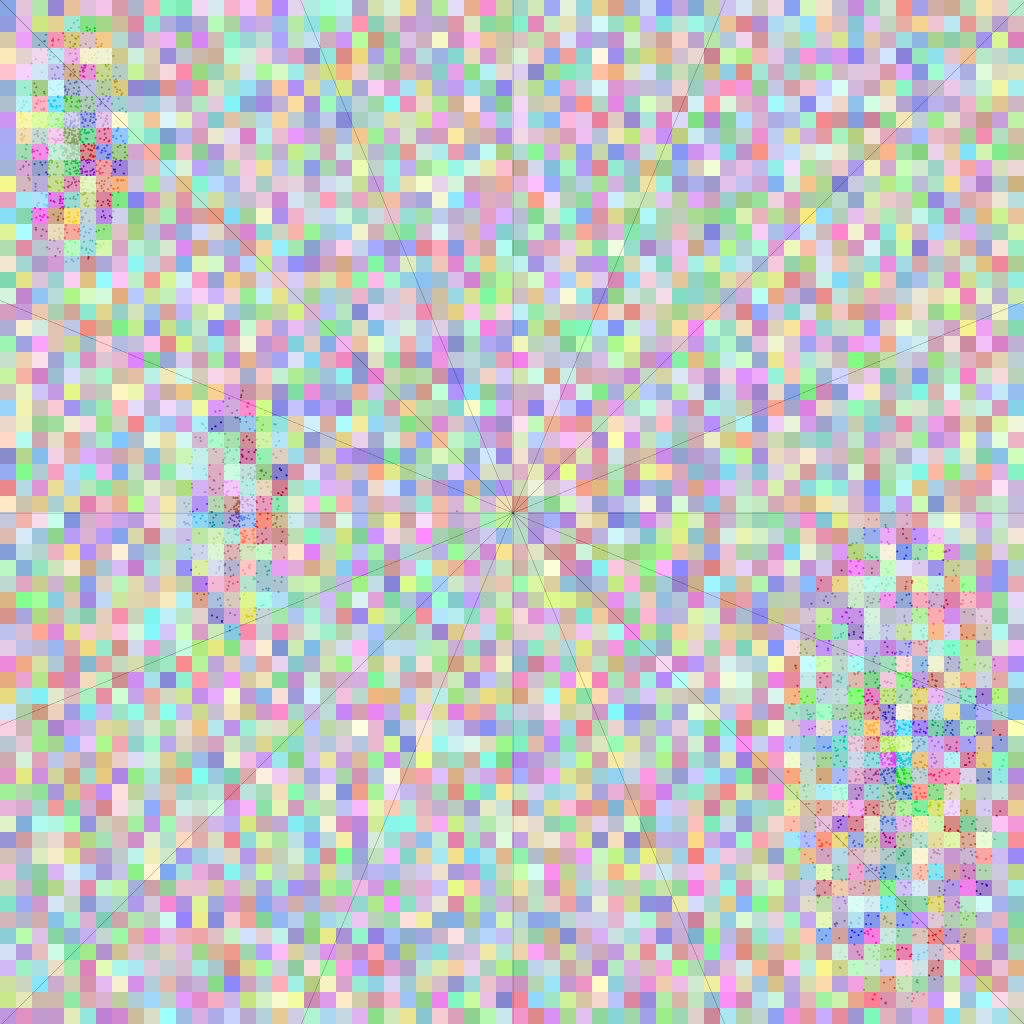

In [6]:
# tile_to_rect[(32,32)]
# (0.5, 0.5, 0.515625, 0.515625)
_render_tiles_, _render_points_, _render_rays_ = True, True, True
xpt, ypt = round(0.5 + (0.515625 - 0.5) * random.random(),6), round(0.5 + (0.515625 - 0.5) * random.random(),6) 
xpt, ypt = 0.5+10e-4,0.5+10e-4

svg = [f'<svg x="0" y="0" width="1024" height="1024" viewBox="0.0 0.0 1.0 1.0">']
svg.append(f'<rect x="0" y="0" width="1.0" height="1.0" fill="#ffffff"/>')

tile_to_rect = {}
if _render_tiles_:
    for xi in range(num_of_tiles):
        x0, x1 = xi/float(num_of_tiles), (xi+1)/float(num_of_tiles)
        for yi in range(num_of_tiles):
            y0, y1 = yi/float(num_of_tiles), (yi+1)/float(num_of_tiles)
            tile_to_rect[(xi,yi)] = (x0, y0, x1, y1)
            _color_   = rt.co_mgr.getColor(str((xi,yi)))
            svg.append(f'<rect x="{x0}" y="{y0}" width="{x1-x0}" height="{y1-y0}" fill="{_color_}" fill-opacity="0.5" />')

if _render_points_:
    for i in range(len(df)):
        x,y,xi,yi = df['x'][i], df['y'][i], df['xi'][i], df['yi'][i]
        _color_   = rt.co_mgr.getColor(str((xi,yi)))
        svg.append(f'<circle cx="{x}" cy="{y}" r="0.001" fill="{_color_}"/>')

tiles_intersected_by_rays = set()
if _render_rays_:
    for _sector_ in range(16):
        a0, a1         = _sector_*2*pi/16, (_sector_+1)*2*pi/16
        u0, v0, u1, v1 = cos(a0), sin(a0), cos(a1), sin(a1)
        svg.append(f'<line x1="{xpt}" y1="{ypt}" x2="{xpt+u0*2.0}" y2="{ypt+v0*2.0}" stroke="#000000" stroke-width="0.0001"/>')
        svg.append(f'<line x1="{xpt}" y1="{ypt}" x2="{xpt+u1*2.0}" y2="{ypt+v1*2.0}" stroke="#000000" stroke-width="0.0001"/>')
        for _tile_ in tile_to_rect:
            x0, y0, x1, y1 = tile_to_rect[_tile_]
            if rt.rayIntersectsSegment((xpt, ypt), (u0, v0), (x0, y0), (x0, y1)) or \
               rt.rayIntersectsSegment((xpt, ypt), (u0, v0), (x1, y0), (x1, y1)) or \
               rt.rayIntersectsSegment((xpt, ypt), (u0, v0), (x0, y0), (x1, y0)) or \
               rt.rayIntersectsSegment((xpt, ypt), (u0, v0), (x0, y1), (x1, y1)) or \
               rt.rayIntersectsSegment((xpt, ypt), (u1, v1), (x0, y0), (x0, y1)) or \
               rt.rayIntersectsSegment((xpt, ypt), (u1, v1), (x1, y0), (x1, y1)) or \
               rt.rayIntersectsSegment((xpt, ypt), (u1, v1), (x0, y0), (x1, y0)) or \
               rt.rayIntersectsSegment((xpt, ypt), (u1, v1), (x0, y1), (x1, y1)): tiles_intersected_by_rays.add(_tile_)

svg.append('</svg>')

# num_of_tiles | total tiles | tiles intersected | xpt,   ypt
#           32 |        1024 |               338 | 0.48,  0.48
#           64 |        4096 |               711 | 0.48,  0.48
#           64 |        4096 |               562 | 0.728, 0.128
#           64 |        4096 |               446 | 0.044, 0.936
#           64 |        4096 |               625 | 0.465, 0.813
#           64 |        4096 |               548 | 0.716, 0.105
# /// just looking at the center tile & randomizing within there ///
# 64 | 4096 | 712 | 0.502,    0.509
# 64 | 4096 | 712 | 0.514,    0.509
# 64 | 4096 | 712 | 0.51,     0.505
# 64 | 4096 | 710 | 0.512,    0.511
# 64 | 4096 | 711 | 0.506,    0.513
# 64 | 4096 | 712 | 0.508006, 0.505877
# 64 | 4096 | 712 | 0.512125, 0.508032
# 64 | 4096 | 710 | 0.510063, 0.509533
# 64 | 4096 | 712 | 0.504302, 0.501294
# 64 | 4096 | 712 | 0.508994, 0.500143
# 64 | 4096 | 624 | 0.5,      0.5       # corner of the cell
# 64 | 4096 | 618 | 0.5,      0.515625  # corner of the cell
# 64 | 4096 | 621 | 0.515625, 0.5       # corner of the cell
# 64 | 4096 | 617 | 0.515625, 0.515625  # corner of the cell
# 64 | 4096 | 712 | 0.501,    0.5       # slight offset from the corner
# 64 | 4096 | 715 | 0.501,    0.501     # slight offset from the corner ### Highest Seen So Far
#
print(f'{num_of_tiles} | {len(tile_to_rect)} | {len(tiles_intersected_by_rays)} | {xpt}, {ypt}')

rt.tile([''.join(svg)])

In [7]:
offtiles_intersected_by_rays = set()
len(offtiles_intersected_by_rays)

0

In [8]:
tile_to_rect = {}
for xi in range(num_of_tiles):
    x0, x1 = xi/float(num_of_tiles), (xi+1)/float(num_of_tiles)
    for yi in range(num_of_tiles):
        y0, y1 = yi/float(num_of_tiles), (yi+1)/float(num_of_tiles)
        tile_to_rect[(xi,yi)] = (x0, y0, x1, y1)
for _iters_ in range(10):
    xpt, ypt = random.random(), random.random()
    xi,  yi  = int(xpt*num_of_tiles), int(ypt*num_of_tiles)
    for _sector_ in range(16):
        a0, a1         = _sector_*2*pi/16, (_sector_+1)*2*pi/16
        u0, v0, u1, v1 = cos(a0), sin(a0), cos(a1), sin(a1)
        for _tile_ in tile_to_rect:
            x0, y0, x1, y1 = tile_to_rect[_tile_]
            if rt.rayIntersectsSegment((xpt, ypt), (u0, v0), (x0, y0), (x0, y1)) or \
               rt.rayIntersectsSegment((xpt, ypt), (u0, v0), (x1, y0), (x1, y1)) or \
               rt.rayIntersectsSegment((xpt, ypt), (u0, v0), (x0, y0), (x1, y0)) or \
               rt.rayIntersectsSegment((xpt, ypt), (u0, v0), (x0, y1), (x1, y1)) or \
               rt.rayIntersectsSegment((xpt, ypt), (u1, v1), (x0, y0), (x0, y1)) or \
               rt.rayIntersectsSegment((xpt, ypt), (u1, v1), (x1, y0), (x1, y1)) or \
               rt.rayIntersectsSegment((xpt, ypt), (u1, v1), (x0, y0), (x1, y0)) or \
               rt.rayIntersectsSegment((xpt, ypt), (u1, v1), (x0, y1), (x1, y1)): offtiles_intersected_by_rays.add((_tile_[0]-xi, _tile_[1]-yi))

# @100 Iterations Per Run : 2092 -> 2188 -> 2213 -> 2222 -> 2237 -> 2256
# then (on top... 1000 iterations)  ... -> 2307 -> 2321 -> 2327 -> 2332 -> 2352 -> ... (2354) -> 2357
# ... final number is 2357 for 64 tiles ... but maybe it's actually 2361 if I had done this more methodically
print(len(offtiles_intersected_by_rays)) # 100 Iterations takes 19.3 seconds | 1000 Iterations takes 3m12s | 10K Iterations takes 67m54s | M1 Pro 16G 

1580


i = 0
for x in offtiles_intersected_by_rays:
    print(x,end=',')
    i += 1
    if i % 20 == 0: print()

xo_min=-31 yo_min=-31 xo_max=31 yo_max=31 | len(offtiles_intersected_by_rays)=1121 | len(xoyo_to_sector)=2848 | len(sectors_seen)=16
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}


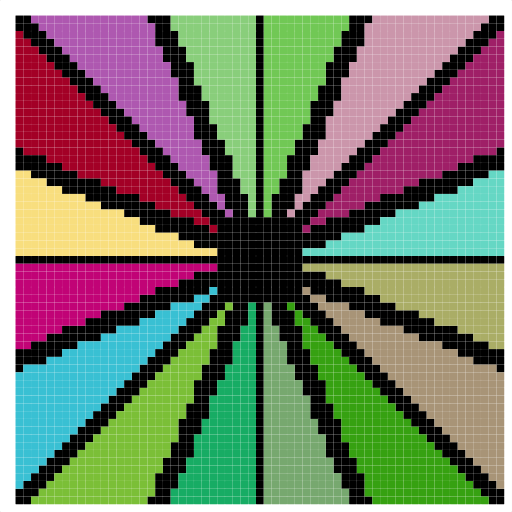

In [9]:
num_of_tiles = 32
_iota_       = 10e-6

# Tile (xi,yi) --> (x0, y0, x1, y1) where the bounds are [x0,x1) and [y0,y1)
tile_to_rect = {}
for xi in range(num_of_tiles):
    x0, x1 = xi/float(num_of_tiles), (xi+1)/float(num_of_tiles)
    for yi in range(num_of_tiles):
        y0, y1 = yi/float(num_of_tiles), (yi+1)/float(num_of_tiles)
        tile_to_rect[(xi,yi)] = (x0, y0, x1, y1)
# Determine which tiles (xo,yo) need to be checked for sector comparisons the hard way
offtiles_intersected_by_rays = set()
for _tile_ in [(0,0), (0, num_of_tiles-1), (num_of_tiles-1, num_of_tiles-1), (num_of_tiles-1, 0)]:
    xi,  yi  = _tile_
    x0,  y0, x1, y1 = tile_to_rect[_tile_]
    xm,  ym         = (x0+x1)/2.0, (y0+y1)/2.0
    _positions_ = [(x0+_iota_, y0+_iota_),(xm, y0+_iota_),(x1-_iota_, y0+_iota_),
                   (x0+_iota_, ym),       (xm, ym),       (x1-_iota_, ym),
                   (x0+_iota_, y1-_iota_),(xm, y1-_iota_),(x1-_iota_, y1-_iota_)]
    for _position_ in _positions_:
        xpt, ypt = _position_
        for _sector_ in range(16):
            a0, a1         = _sector_*2*pi/16, (_sector_+1)*2*pi/16
            u0, v0, u1, v1 = cos(a0), sin(a0), cos(a1), sin(a1)
            for _tile_ in tile_to_rect:
                x0, y0, x1, y1 = tile_to_rect[_tile_]
                if rt.rayIntersectsSegment((xpt, ypt), (u0, v0), (x0, y0), (x0, y1)) or rt.rayIntersectsSegment((xpt, ypt), (u0, v0), (x1, y0), (x1, y1)) or \
                   rt.rayIntersectsSegment((xpt, ypt), (u0, v0), (x0, y0), (x1, y0)) or rt.rayIntersectsSegment((xpt, ypt), (u0, v0), (x0, y1), (x1, y1)) or \
                   rt.rayIntersectsSegment((xpt, ypt), (u1, v1), (x0, y0), (x0, y1)) or rt.rayIntersectsSegment((xpt, ypt), (u1, v1), (x1, y0), (x1, y1)) or \
                   rt.rayIntersectsSegment((xpt, ypt), (u1, v1), (x0, y0), (x1, y0)) or rt.rayIntersectsSegment((xpt, ypt), (u1, v1), (x0, y1), (x1, y1)): offtiles_intersected_by_rays.add((_tile_[0]-xi, _tile_[1]-yi))
# Determine the min and max x/y offsets
xo_min, xo_max, yo_min, yo_max = 0, 0, 0, 0 # xi_min=-63 yi_min=-63 xi_max=63 yi_max=63 // for num_of_tiles = 64
for _xyo_ in offtiles_intersected_by_rays:
    xo, yo = _xyo_
    xo_min, xo_max = min(xo, xo_min), max(xo, xo_max)
    yo_min, yo_max = min(yo, yo_min), max(yo, yo_max)
xoyo_to_sector, sectors_seen = {}, set()
for xo in range(xo_min, xo_max+1):
    for yo in range(yo_min, yo_max+1):
        if (xo,yo) in offtiles_intersected_by_rays: continue
        xm, ym   = xo, yo
        _sector_ = int(16*(atan2(ym, xm)+pi)/(2*pi))
        xoyo_to_sector[(xo,yo)] = _sector_
        sectors_seen.add(_sector_)
print(f'{xo_min=} {yo_min=} {xo_max=} {yo_max=} | {len(offtiles_intersected_by_rays)=} | {len(xoyo_to_sector)=} | {len(sectors_seen)=}')
print(sectors_seen)
svg = [f'<svg x="0" y="0" width="512" height="512" viewBox="0 0 {num_of_tiles*2+2} {num_of_tiles*2+2}">']
svg.append(f'<rect x="0" y="0" width="{num_of_tiles*2+2}" height="{num_of_tiles*2+2}" rx="0.05" fill="#ffffff" />')
_lu_ = {'xo':[], 'yo':[], 'sector':[]}
for _xyo_ in offtiles_intersected_by_rays:
    xo, yo = _xyo_
    svg.append(f'<rect x="{xo+(num_of_tiles+1)}" y="{yo+num_of_tiles+1}" width="1" height="1" rx="0.05" fill="#000000" />')
    _lu_['xo'].append(xo), _lu_['yo'].append(yo), _lu_['sector'].append(-1)
for _xyo_ in xoyo_to_sector:
    xo, yo   = _xyo_
    _sector_ = xoyo_to_sector[_xyo_]
    _color_  = rt.co_mgr.getColor(_sector_)
    svg.append(f'<rect x="{xo+(num_of_tiles+1)}" y="{yo+num_of_tiles+1}" width="1" height="1" rx="0.05" fill="{_color_}" />')
    _lu_['xo'].append(xo), _lu_['yo'].append(yo), _lu_['sector'].append(_sector_)
svg.append('</svg>')
df_xoyo_sector = pl.DataFrame(_lu_)
rt.tile([''.join(svg)])

In [20]:
#num_of_pts   = [1, 2, 3]
num_of_pts   = [2, 2, 1]
circle_geoms = [(5,5,1),(20,10,2),(8,8,1)]
colors       = ['#ff0000','#006400','#0000ff']
_xvals_, _yvals_, _weights_, _colors_ = [12.0], [8.0], [1.0], ['#000000']
for i in range(len(num_of_pts)):
    for j in range(num_of_pts[i]):
        a, l = random.random() * 2 * pi, random.random() * circle_geoms[i][2]
        x, y = circle_geoms[i][0] + l * cos(a), circle_geoms[i][1] + l * sin(a)
        _xvals_.append(x), _yvals_.append(y), _weights_.append(1.0), _colors_.append(colors[i])
print(f'Total Points = {len(_xvals_)}')

Total Points = 6


In [21]:
df = pl.DataFrame({'x':_xvals_, 'y':_yvals_, 'w':_weights_, 'c':_colors_}).with_row_index('__index__')
df = df.with_columns((0.02 + 0.96 * (pl.col('x') - pl.col('x').min())/(pl.col('x').max() - pl.col('x').min())).alias('x'), 
                     (0.02 + 0.96 * (pl.col('y') - pl.col('y').min())/(pl.col('y').max() - pl.col('y').min())).alias('y'))
df_weight_sum = df['w'].sum()
# vvv -- PERFORMANCE ISSUES
# Explode
df = df.with_columns(pl.struct(['x','y','__index__']).implode().alias('_implode_')) \
        .explode('_implode_')                                            \
        .with_columns(pl.col('_implode_').struct.field('x')        .alias('_xo_'),
                      pl.col('_implode_').struct.field('y')        .alias('_yo_'),
                      pl.col('_implode_').struct.field('__index__').alias('_indexo_'))
df = df.filter(pl.col('__index__') != pl.col('_indexo_')) # don't compare the point with itself
# Sector Determination (per point basis)
_dx_ = pl.col('_xo_') - pl.col('x')
_dy_ = pl.col('_yo_') - pl.col('y')
df   = df.with_columns(((16*(pl.arctan2(_dy_, _dx_) + pl.lit(pi))/(pl.lit(2*pi))).cast(pl.Int64)).alias('sector'))
# Sector Summation
df   = df.group_by(['__index__','x','y','sector']).agg((pl.col('w').sum()).alias('_w_sum_'), (pl.col('w').sum() / df_weight_sum).alias('_w_ratio_'))
# ^^^ -- PERFORMANCE ISSUES
df_old = df
df # 13.3s | M1 Pro 16G | num_of_pts   = [3_000, 5_000, 1_500]

shape: (21, 6)
┌───────────┬──────────┬──────────┬────────┬─────────┬───────────┐
│ __index__ ┆ x        ┆ y        ┆ sector ┆ _w_sum_ ┆ _w_ratio_ │
│ ---       ┆ ---      ┆ ---      ┆ ---    ┆ ---     ┆ ---       │
│ u32       ┆ f64      ┆ f64      ┆ i64    ┆ f64     ┆ f64       │
╞═══════════╪══════════╪══════════╪════════╪═════════╪═══════════╡
│ 1         ┆ 0.02     ┆ 0.02     ┆ 10     ┆ 2.0     ┆ 0.333333  │
│ 1         ┆ 0.02     ┆ 0.02     ┆ 9      ┆ 1.0     ┆ 0.166667  │
│ 0         ┆ 0.462545 ┆ 0.659813 ┆ 9      ┆ 1.0     ┆ 0.166667  │
│ 5         ┆ 0.204119 ┆ 0.68033  ┆ 8      ┆ 2.0     ┆ 0.333333  │
│ 2         ┆ 0.028765 ┆ 0.128453 ┆ 11     ┆ 1.0     ┆ 0.166667  │
│ …         ┆ …        ┆ …        ┆ …      ┆ …       ┆ …         │
│ 3         ┆ 0.953902 ┆ 0.98     ┆ 2      ┆ 1.0     ┆ 0.166667  │
│ 2         ┆ 0.028765 ┆ 0.128453 ┆ 10     ┆ 1.0     ┆ 0.166667  │
│ 0         ┆ 0.462545 ┆ 0.659813 ┆ 8      ┆ 1.0     ┆ 0.166667  │
│ 0         ┆ 0.462545 ┆ 0.659813 ┆ 15     ┆ 1.0     ┆ 0.166667  │
│ 2         ┆ 0.028765 ┆ 0.128453 ┆ 9      ┆ 2.0     ┆ 0.333333  │
└───────────┴──────────┴──────────┴────────┴─────────┴───────────┘

In [22]:
df = pl.DataFrame({'x':_xvals_, 'y':_yvals_, 'w':_weights_, 'c':_colors_}).with_row_index('__index__')
df = df.with_columns((0.02 + 0.96 * (pl.col('x') - pl.col('x').min())/(pl.col('x').max() - pl.col('x').min())).alias('x'), 
                     (0.02 + 0.96 * (pl.col('y') - pl.col('y').min())/(pl.col('y').max() - pl.col('y').min())).alias('y'))
df_weight_sum = df['w'].sum()
# Determine the x/y tile of each point (xi,yi)
df_w_tile = df.with_columns((pl.col('x') * num_of_tiles).cast(pl.Int16).alias('xi'), 
                            (pl.col('y') * num_of_tiles).cast(pl.Int16).alias('yi'))
# Determine the sum of the weights in each tile (tile_sum)
df_tile_sums = df_w_tile.group_by(['xi','yi']).agg(pl.col('w').sum().alias('tile_sum'))
# Cross join all filled in tiles with the original points & then compute the x/y offset (xo,yo)
df           = df_w_tile.join(df_tile_sums, how='cross').rename({'xi_right':'xi_tile_sums', 'yi_right':'yi_tile_sums'}). \
                                                         with_columns((pl.col('xi_tile_sums') - pl.col('xi')).alias('xo'),
                                                                      (pl.col('yi_tile_sums') - pl.col('yi')).alias('yo'))
# Pull the sector information from the df_xoyo_sector dataframe ... any sector == -1 needs to be done the hard way
# ... hard way == atan2 on the individual point level
df          = df.join(df_xoyo_sector, on=['xo','yo'])
# Separate into "easy way" and "hard way"
df_easy_way = df.filter(pl.col('sector') != -1)
df_hard_way = df.filter(pl.col('sector') == -1).join(df_w_tile.drop(['c']), left_on=['xi_tile_sums','yi_tile_sums'], right_on=['xi','yi']).filter(pl.col('__index__') != pl.col('__index___right'))
# Hard way calculation ... determine the sector on a per point basis
_dx_, _dy_ = pl.col('x_right') - pl.col('x'), pl.col('y_right') - pl.col('y')
df_hard_way = df_hard_way.with_columns(((16*(pl.arctan2(_dy_, _dx_) + pl.lit(pi))/(pl.lit(2*pi))).cast(pl.Int64)).alias('sector'))
# Sector Summation
df_easy_way = df_easy_way.group_by(['__index__','x','y','sector']).agg(pl.col('tile_sum').sum().alias('_w_sum_'))
df_hard_way = df_hard_way.group_by(['__index__','x','y','sector']).agg(pl.col('w_right').sum().alias('_w_sum_'))
df          = pl.concat([df_easy_way, df_hard_way])
df          = df.group_by(['__index__','x','y','sector']).agg(pl.col('_w_sum_').sum()).with_columns((pl.col('_w_sum_') / df_weight_sum).alias('_w_ratio_'))
df_new = df
df # 4.6s | M1 Pro 16G | num_of_pts   = [3_000, 5_000, 1_500]

shape: (21, 6)
┌───────────┬──────────┬──────────┬────────┬─────────┬───────────┐
│ __index__ ┆ x        ┆ y        ┆ sector ┆ _w_sum_ ┆ _w_ratio_ │
│ ---       ┆ ---      ┆ ---      ┆ ---    ┆ ---     ┆ ---       │
│ u32       ┆ f64      ┆ f64      ┆ i64    ┆ f64     ┆ f64       │
╞═══════════╪══════════╪══════════╪════════╪═════════╪═══════════╡
│ 2         ┆ 0.028765 ┆ 0.128453 ┆ 11     ┆ 1.0     ┆ 0.166667  │
│ 4         ┆ 0.98     ┆ 0.806625 ┆ 0      ┆ 2.0     ┆ 0.333333  │
│ 4         ┆ 0.98     ┆ 0.806625 ┆ 1      ┆ 2.0     ┆ 0.333333  │
│ 3         ┆ 0.953902 ┆ 0.98     ┆ 1      ┆ 2.0     ┆ 0.333333  │
│ 0         ┆ 0.462545 ┆ 0.659813 ┆ 15     ┆ 1.0     ┆ 0.166667  │
│ …         ┆ …        ┆ …        ┆ …      ┆ …       ┆ …         │
│ 2         ┆ 0.028765 ┆ 0.128453 ┆ 9      ┆ 2.0     ┆ 0.333333  │
│ 4         ┆ 0.98     ┆ 0.806625 ┆ 12     ┆ 1.0     ┆ 0.166667  │
│ 5         ┆ 0.204119 ┆ 0.68033  ┆ 8      ┆ 2.0     ┆ 0.333333  │
│ 1         ┆ 0.02     ┆ 0.02     ┆ 11     ┆ 2.0     ┆ 0.333333  │
│ 5         ┆ 0.204119 ┆ 0.68033  ┆ 3      ┆ 2.0     ┆ 0.333333  │
└───────────┴──────────┴──────────┴────────┴─────────┴───────────┘

In [23]:
# With tile optimization: 76.18967080116272, Without tile optimization: 88.3563129901886
# ... which doesn't make sense w/ the numbers above -- those are 15s (no opt) and 5s (tile opt)
t0 = time.time()
udspvs_tiles = UDistScatterPlotsViaSectorsTileOpt(_xvals_, _yvals_, _weights_, _colors_, vector_scalar=0.01, iterations=1, debug=True, num_of_tiles=32)
t1 = time.time()
udspvs       = UDistScatterPlotsViaSectors       (_xvals_, _yvals_, _weights_, _colors_, vector_scalar=0.01, iterations=1, debug=True)
t2 = time.time()
print(f'With tile optimization: {t1 - t0}, Without tile optimization: {t2 - t1}')

With tile optimization: 0.016741037368774414, Without tile optimization: 0.007045745849609375


In [ ]:
print(f"{len(udspvs_tiles.df_at_iteration_start)=}      | {udspvs_tiles.df_at_iteration_start[0].shape}")
print(f"{len(udspvs_tiles.df_all_sectors)=}             | {udspvs_tiles.df_all_sectors[0].shape}")
print(f"{len(udspvs_tiles.df_tile_determinations)=}     | {udspvs_tiles.df_tile_determinations[0].shape}")
print(f"{len(udspvs_tiles.df_tile_sums)=}               | {udspvs_tiles.df_tile_sums[0].shape}")
print(f"{len(udspvs_tiles.df_cross_join_tile_offsets)=} | {udspvs_tiles.df_cross_join_tile_offsets[0].shape}")
print(f"{len(udspvs_tiles.df_join_sector_info)=}        | {udspvs_tiles.df_join_sector_info[0].shape}")
print(f"{len(udspvs_tiles.df_separate_easy_way)=}       | {udspvs_tiles.df_separate_easy_way[0].shape}")
print(f"{len(udspvs_tiles.df_separate_hard_way)=}       | {udspvs_tiles.df_separate_hard_way[0].shape}")
print(f"{len(udspvs_tiles.df_hard_way_arctangents)=}    | {udspvs_tiles.df_hard_way_arctangents[0].shape}")
print(f"{len(udspvs_tiles.df_sector_sums)=}             | {udspvs_tiles.df_sector_sums[0].shape}")
print(f"{len(udspvs_tiles.df_sector_fill)=}             | {udspvs_tiles.df_sector_fill[0].shape}")
print(f"{len(udspvs_tiles.df_sector_angles)=}           | {udspvs_tiles.df_sector_angles[0].shape}")
print(f"{len(udspvs_tiles.df_sector_angles_joined)=}    | {udspvs_tiles.df_sector_angles_joined[0].shape}")
print(f"{len(udspvs_tiles.df_fully_filled)=}            | {udspvs_tiles.df_fully_filled[0].shape}")
print(f"{len(udspvs_tiles.df_uv)=}                      | {udspvs_tiles.df_uv[0].shape}")

len(udspvs_tiles.df_all_sectors)=1             | (96, 4)
len(udspvs_tiles.df_at_iteration_start)=1      | (6, 5)
len(udspvs_tiles.df_all_sectors)=1             | (96, 4)
len(udspvs_tiles.df_sector_fill)=1             | (96, 6)
len(udspvs_tiles.df_tile_sums)=1               | (6, 3)
len(udspvs_tiles.df_tile_determinations)=1     | (6, 7)
len(udspvs_tiles.df_cross_join_tile_offsets)=1 | (36, 12)
len(udspvs_tiles.df_join_sector_info)=1        | (52, 13)
len(udspvs_tiles.df_separate_easy_way)=1       | (20, 13)
len(udspvs_tiles.df_separate_hard_way)=1       | (20, 17)
len(udspvs_tiles.df_hard_way_arctangents)=1    | (20, 17)
len(udspvs_tiles.df_sector_sums)=1             | (21, 6)
len(udspvs_tiles.df_sector_angles)=1           | (16, 24)
len(udspvs_tiles.df_sector_angles_joined)=1    | (96, 29)
len(udspvs_tiles.df_fully_filled)=1            | (96, 54)
len(udspvs_tiles.df_uv)=1                      | (6, 5)


In [25]:
print(f"{len(udspvs.df_at_iteration_start)=}          | {udspvs.df_at_iteration_start[0].shape}")
print(f"{len(udspvs.df_sector_sums)=}                 | {udspvs.df_sector_sums[0].shape}")
print(f"{len(udspvs.df_sector_fill)=}                 | {udspvs.df_sector_fill[0].shape}")
print(f"{len(udspvs.df_sector_determinations)=}       | {udspvs.df_sector_determinations[0].shape}")
print(f"{len(udspvs.df_sector_angles)=}               | {udspvs.df_sector_angles[0].shape}")
print(f"{len(udspvs.df_sector_angles_joined)=}        | {udspvs.df_sector_angles_joined[0].shape}")
print(f"{len(udspvs.df_fully_filled)=}                | {udspvs.df_fully_filled[0].shape}")
print(f"{len(udspvs.df_uv)=}                          | {udspvs.df_uv[0].shape}")

len(udspvs.df_at_iteration_start)=1          | (6, 5)
len(udspvs.df_sector_sums)=1                 | (21, 6)
len(udspvs.df_sector_fill)=1                 | (96, 6)
len(udspvs.df_sector_determinations)=1       | (30, 10)
len(udspvs.df_sector_angles)=1               | (16, 24)
len(udspvs.df_sector_angles_joined)=1        | (96, 29)
len(udspvs.df_fully_filled)=1                | (96, 54)
len(udspvs.df_uv)=1                          | (6, 5)


In [26]:
udspvs_tiles.df_separate_hard_way[0]

shape: (20, 17)
┌───────────┬──────────┬──────────┬─────┬───┬─────────────────┬──────────┬──────────┬─────────┐
│ __index__ ┆ x        ┆ y        ┆ w   ┆ … ┆ __index___right ┆ x_right  ┆ y_right  ┆ w_right │
│ ---       ┆ ---      ┆ ---      ┆ --- ┆   ┆ ---             ┆ ---      ┆ ---      ┆ ---     │
│ u32       ┆ f64      ┆ f64      ┆ f64 ┆   ┆ u32             ┆ f64      ┆ f64      ┆ f64     │
╞═══════════╪══════════╪══════════╪═════╪═══╪═════════════════╪══════════╪══════════╪═════════╡
│ 5         ┆ 0.204119 ┆ 0.68033  ┆ 1.0 ┆ … ┆ 0               ┆ 0.462545 ┆ 0.659813 ┆ 1.0     │
│ 2         ┆ 0.028765 ┆ 0.128453 ┆ 1.0 ┆ … ┆ 1               ┆ 0.02     ┆ 0.02     ┆ 1.0     │
│ 0         ┆ 0.462545 ┆ 0.659813 ┆ 1.0 ┆ … ┆ 5               ┆ 0.204119 ┆ 0.68033  ┆ 1.0     │
│ 3         ┆ 0.953902 ┆ 0.98     ┆ 1.0 ┆ … ┆ 5               ┆ 0.204119 ┆ 0.68033  ┆ 1.0     │
│ 1         ┆ 0.02     ┆ 0.02     ┆ 1.0 ┆ … ┆ 3               ┆ 0.953902 ┆ 0.98     ┆ 1.0     │
│ …         ┆ …        ┆ …        ┆ …   ┆ … ┆ …               ┆ …        ┆ …        ┆ …       │
│ 1         ┆ 0.02     ┆ 0.02     ┆ 1.0 ┆ … ┆ 2               ┆ 0.028765 ┆ 0.128453 ┆ 1.0     │
│ 5         ┆ 0.204119 ┆ 0.68033  ┆ 1.0 ┆ … ┆ 2               ┆ 0.028765 ┆ 0.128453 ┆ 1.0     │
│ 2         ┆ 0.028765 ┆ 0.128453 ┆ 1.0 ┆ … ┆ 5               ┆ 0.204119 ┆ 0.68033  ┆ 1.0     │
│ 3         ┆ 0.953902 ┆ 0.98     ┆ 1.0 ┆ … ┆ 1               ┆ 0.02     ┆ 0.02     ┆ 1.0     │
│ 5         ┆ 0.204119 ┆ 0.68033  ┆ 1.0 ┆ … ┆ 3               ┆ 0.953902 ┆ 0.98     ┆ 1.0     │
└───────────┴──────────┴──────────┴─────┴───┴─────────────────┴──────────┴──────────┴─────────┘

In [27]:
udspvs_tiles.df_separate_easy_way[0]

shape: (20, 13)
┌───────────┬──────────┬──────────┬─────┬───┬──────────┬─────┬─────┬────────┐
│ __index__ ┆ x        ┆ y        ┆ w   ┆ … ┆ tile_sum ┆ xo  ┆ yo  ┆ sector │
│ ---       ┆ ---      ┆ ---      ┆ --- ┆   ┆ ---      ┆ --- ┆ --- ┆ ---    │
│ u32       ┆ f64      ┆ f64      ┆ f64 ┆   ┆ f64      ┆ i16 ┆ i16 ┆ i64    │
╞═══════════╪══════════╪══════════╪═════╪═══╪══════════╪═════╪═════╪════════╡
│ 4         ┆ 0.98     ┆ 0.806625 ┆ 1.0 ┆ … ┆ 1.0      ┆ -31 ┆ -25 ┆ 1      │
│ 4         ┆ 0.98     ┆ 0.806625 ┆ 1.0 ┆ … ┆ 1.0      ┆ -31 ┆ -21 ┆ 1      │
│ 3         ┆ 0.953902 ┆ 0.98     ┆ 1.0 ┆ … ┆ 1.0      ┆ -30 ┆ -27 ┆ 1      │
│ 4         ┆ 0.98     ┆ 0.806625 ┆ 1.0 ┆ … ┆ 1.0      ┆ -25 ┆ -4  ┆ 0      │
│ 4         ┆ 0.98     ┆ 0.806625 ┆ 1.0 ┆ … ┆ 1.0      ┆ -17 ┆ -4  ┆ 0      │
│ …         ┆ …        ┆ …        ┆ …   ┆ … ┆ …        ┆ …   ┆ …   ┆ …      │
│ 0         ┆ 0.462545 ┆ 0.659813 ┆ 1.0 ┆ … ┆ 1.0      ┆ 17  ┆ 4   ┆ 8      │
│ 5         ┆ 0.204119 ┆ 0.68033  ┆ 1.0 ┆ … ┆ 1.0      ┆ 25  ┆ 4   ┆ 8      │
│ 2         ┆ 0.028765 ┆ 0.128453 ┆ 1.0 ┆ … ┆ 1.0      ┆ 30  ┆ 27  ┆ 9      │
│ 2         ┆ 0.028765 ┆ 0.128453 ┆ 1.0 ┆ … ┆ 1.0      ┆ 31  ┆ 21  ┆ 9      │
│ 1         ┆ 0.02     ┆ 0.02     ┆ 1.0 ┆ … ┆ 1.0      ┆ 31  ┆ 25  ┆ 9      │
└───────────┴──────────┴──────────┴─────┴───┴──────────┴─────┴─────┴────────┘

In [28]:
udspvs_tiles.df_tile_determinations[0]

shape: (6, 7)
┌───────────┬──────────┬──────────┬─────┬─────────┬─────┬─────┐
│ __index__ ┆ x        ┆ y        ┆ w   ┆ c       ┆ xi  ┆ yi  │
│ ---       ┆ ---      ┆ ---      ┆ --- ┆ ---     ┆ --- ┆ --- │
│ u32       ┆ f64      ┆ f64      ┆ f64 ┆ str     ┆ i16 ┆ i16 │
╞═══════════╪══════════╪══════════╪═════╪═════════╪═════╪═════╡
│ 0         ┆ 0.462545 ┆ 0.659813 ┆ 1.0 ┆ #000000 ┆ 14  ┆ 21  │
│ 1         ┆ 0.02     ┆ 0.02     ┆ 1.0 ┆ #ff0000 ┆ 0   ┆ 0   │
│ 2         ┆ 0.028765 ┆ 0.128453 ┆ 1.0 ┆ #ff0000 ┆ 0   ┆ 4   │
│ 3         ┆ 0.953902 ┆ 0.98     ┆ 1.0 ┆ #006400 ┆ 30  ┆ 31  │
│ 4         ┆ 0.98     ┆ 0.806625 ┆ 1.0 ┆ #006400 ┆ 31  ┆ 25  │
│ 5         ┆ 0.204119 ┆ 0.68033  ┆ 1.0 ┆ #0000ff ┆ 6   ┆ 21  │
└───────────┴──────────┴──────────┴─────┴─────────┴─────┴─────┘